In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_info = pd.read_csv('cc_info.csv')
df_tran = pd.read_csv('transactions.csv',parse_dates=['date'])

In [3]:
df_info.head(5)

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
df_tran.head(5)

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
df_info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [6]:
df_tran.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [7]:
df = pd.merge(df_tran, df_info, on='credit_card')
df.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

In [8]:
df.shape

(294588, 9)

In [9]:
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['week'] = df['date'].apply(lambda x: x.week)
df['hour'] = df['date'].apply(lambda x: x.hour)
df.head(5)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,year,month,day,week,hour
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,2015,9,11,37,0
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,2015,10,24,43,22
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,2015,10,26,44,18
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,2015,10,22,43,19
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,2015,10,26,44,20


In [10]:
print(df['year'].unique())

[2015]


In [11]:
data = df.groupby(['month'])['transaction_dollar_amount'].count()
data

month
7      4381
8     99167
9     96026
10    95014
Name: transaction_dollar_amount, dtype: int64

### Question 1

In [12]:
def monthly_tran(df):
    total_trans = df['transaction_dollar_amount'].sum()
    credit_limit = df['credit_card_limit'].values[0]
    
    return pd.Series([total_trans, credit_limit], index=['total_transaction', 'credit_limit'])

In [13]:
underlimit = df.groupby(['credit_card','month']).apply(monthly_tran).reset_index()
underlimit['under_limit'] = (underlimit['total_transaction'] > underlimit['credit_limit']).astype(int)
result = underlimit.groupby('credit_card')['under_limit'].sum().reset_index()
lists = result[result['under_limit'] == 0][['credit_card']]
lists

,credit_card
0,1003715054175576
1,1013870087888817
2,1023820165155391
3,1073931538936472
4,1077622576192810
...,...
978,9946917923319410
979,9958678964376192
980,9961694231875562
981,9981251982982618


862 customers never went above the limitation

### Question 2

In [14]:
def notice_list(df,month,day):
    df_date = df[(df['month'] == month) & (df['day'] <= day)]
    limit = df_date.groupby('credit_card')['credit_card_limit'].min().reset_index()
    spend = df_date.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    df_all = pd.merge(spend,limit,on='credit_card')
    df_over = df_all[df_all['transaction_dollar_amount']>df_all['credit_card_limit']]
    
    return df_over

In [15]:
notice_list(df,month=10,day=17)

,credit_card,transaction_dollar_amount,credit_card_limit
238,3276369883343727,10538.55,10000
285,3676109815092640,2007.41,2000
597,6292410823269309,2046.93,2000
640,6766253113444560,2842.09,2000
699,7299183791723634,7161.61,7000
798,8117664962797683,2299.83,2000
873,8972201384562696,6035.24,5000
936,9632319271199136,4459.61,4000


### Question 3

In [16]:
median = df.groupby('credit_card')['Long','Lat'].median().reset_index()
median = median.rename(columns={'Long': 'Long_median', 'Lat': 'Lat_median'})
df_all = pd.merge(df,median,on='credit_card')
df_all['dis'] = np.sqrt((df_all['Long_median']-df_all['Long'])**2+(df_all['Lat_median']-df_all['Lat'])**2)

In [17]:
median = df_all.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
median = median.rename(columns={'transaction_dollar_amount': 'transaction_median'})
df_all = pd.merge(df_all,median,on='credit_card')

In [18]:
df_all['transaction_to_median'] = df_all['transaction_dollar_amount'] / df_all['transaction_median']
df_all['transaction_to_limit'] = df_all['transaction_dollar_amount'] / df_all['credit_card_limit']

In [19]:
labels = ['Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 'year',
          'month', 'day', 'Long_median', 'Lat_median', 'transaction_median']
df_drop = df_all.drop(labels=labels, axis=1)
df_drop.head(5)

,credit_card,date,transaction_dollar_amount,week,hour,dis,transaction_to_median,transaction_to_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,37,0,0.043645,0.467086,0.002189
1,1003715054175576,2015-10-24 22:23:08,103.15,43,22,0.064817,1.100501,0.005158
2,1003715054175576,2015-10-26 18:19:36,48.55,44,18,0.070094,0.517977,0.002427
3,1003715054175576,2015-10-22 19:41:10,136.18,43,19,0.060071,1.452897,0.006809
4,1003715054175576,2015-10-26 20:08:22,71.82,44,20,0.081329,0.766243,0.003591


In [20]:
x = df_drop[['transaction_dollar_amount','week', 'hour', 'dis', 'transaction_to_median', 'transaction_to_limit']]
scaler = StandardScaler()
norm_x = scaler.fit_transform(x)
norm_x

array([[-0.33875725, -0.13609616, -2.33045568, -0.11248539, -0.27604892,
        -0.33720796],
       [ 0.13751443,  1.45386891,  0.74551652, -0.11126415, -0.07816039,
        -0.11071913],
       [-0.30049186,  1.71886309,  0.18624885, -0.11095976, -0.26014984,
        -0.31901103],
       ...,
       [-0.06793138,  0.3938922 , -0.09338499, -0.10979788, -0.23696786,
         0.48179376],
       [ 0.46561805, -0.66608451,  0.18624885, -0.11272768, -0.07827887,
         1.32755043],
       [ 0.54832584, -0.93107869, -2.33045568, -0.11069477, -0.05367981,
         1.45865479]])

### Isolation Forest (Unsupervised Outlier Detection)

In [21]:
iso_forest = IsolationForest(n_estimators=100, max_samples=len(norm_x), random_state=42, contamination=0.01)

iso_forest = iso_forest.fit(norm_x)
y_pred = iso_forest.predict(norm_x)

print("Predicted Anomalous Data Points: ", len(y_pred[y_pred == -1]))
print("Predicted Non Anomalous Data Points: ", len(y_pred[y_pred == 1]))

Predicted Anomalous Data Points:  2946
Predicted Non Anomalous Data Points:  291642


In [22]:
# adding the predicted y to the sampled dataset
df_drop["y_pred_iso"] = y_pred
df_drop

,credit_card,date,transaction_dollar_amount,week,hour,dis,transaction_to_median,transaction_to_limit,y_pred_iso
0,1003715054175576,2015-09-11 00:32:40,43.78,37,0,0.043645,0.467086,0.002189,1
1,1003715054175576,2015-10-24 22:23:08,103.15,43,22,0.064817,1.100501,0.005158,1
2,1003715054175576,2015-10-26 18:19:36,48.55,44,18,0.070094,0.517977,0.002427,1
3,1003715054175576,2015-10-22 19:41:10,136.18,43,19,0.060071,1.452897,0.006809,1
4,1003715054175576,2015-10-26 20:08:22,71.82,44,20,0.081329,0.766243,0.003591,1
...,...,...,...,...,...,...,...,...,...
294583,9999757432802760,2015-09-10 19:43:33,127.23,37,19,0.019718,0.971666,0.021205,1
294584,9999757432802760,2015-08-06 21:00:13,84.90,32,21,0.076493,0.648389,0.014150,1
294585,9999757432802760,2015-09-22 16:15:47,77.54,39,16,0.090238,0.592180,0.012923,1
294586,9999757432802760,2015-08-27 18:08:24,144.05,35,18,0.039444,1.100122,0.024008,1


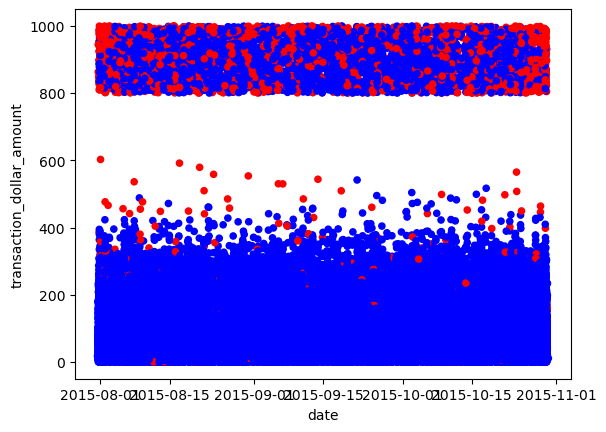

In [23]:
colors = np.where(df_drop["y_pred_iso"]==1,'b','r')
df_drop.plot.scatter(x="date",y="transaction_dollar_amount",c=colors)
plt.show()